## **Group 13**

# ***Important***
* Dataset must be compressed in .zip before loaded to the model
  * Subfolders inside dataset folders: **indoor** and **outdoor** only, the model will manage the splitting of the data to train, test, validation

* Change **[!unzip or ZipFile, data_dir, outdoor_dir]** to the name of the zip file containing the dataset

In [1]:
import os
import random
import torch
import zipfile  # For jupyter extract zip
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder  # To load the dataset
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from PIL import Image  # To change to .png
import numpy as np

# For split
import shutil

# For CNN model
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Performance metrics
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if (torch.cuda.is_available()):
  print("CUDA is being used")
else:
  print("CUDA is not available, thus CPU is being used")

CUDA is being used


In [3]:
# for colab
!unzip image_dataset.zip

Archive:  image_dataset.zip
   creating: image_dataset/
   creating: image_dataset/indoor/
  inflating: image_dataset/indoor/1-resized.jpg  
  inflating: image_dataset/indoor/10-resized.jpg  
  inflating: image_dataset/indoor/11-resized.jpg  
  inflating: image_dataset/indoor/111-resized.jpg  
  inflating: image_dataset/indoor/112-resized.jpg  
  inflating: image_dataset/indoor/1123-resized.jpg  
  inflating: image_dataset/indoor/113-resized.jpg  
  inflating: image_dataset/indoor/114-resized.jpg  
  inflating: image_dataset/indoor/12-resized.jpg  
  inflating: image_dataset/indoor/121-resized.jpg  
  inflating: image_dataset/indoor/123-resized.jpg  
  inflating: image_dataset/indoor/13-resized.jpg  
  inflating: image_dataset/indoor/14-resized.jpg  
  inflating: image_dataset/indoor/143-resized.jpg  
  inflating: image_dataset/indoor/15-resized.jpg  
  inflating: image_dataset/indoor/16-resized.jpg  
  inflating: image_dataset/indoor/166-resized.jpg  
  inflating: image_dataset/indoor

In [4]:
# # for jupyter
# with zipfile.ZipFile('./image_dataset.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')

In [5]:
# Path to the data folder
data_dir = './image_dataset'

### **Rename images to sequential numbers**

**This one have to be before loading the dataset**

In [6]:
# Rename images to sequential numbers
# This one have to be before loading the dataset

# Rename the files in each folder to numbers
def rename_files(folder_path):
    file_list = sorted(os.listdir(folder_path))
    for i, file_name in enumerate(file_list):
        file_path = os.path.join(folder_path, file_name)
        new_file_name = f"{i + 1:04d}.png"  # Rename files as 0001.png, 0002.png, ...
        new_file_path = os.path.join(folder_path, new_file_name)
        os.rename(file_path, new_file_path)

# Rename files in the "indoor" folder
indoor_folder = os.path.join(data_dir, 'indoor')
rename_files(indoor_folder)

# Rename files in the "outdoor" folder
outdoor_folder = os.path.join(data_dir, 'outdoor')
rename_files(outdoor_folder)

### **Change filetype to .png**

In [7]:
# Change filetype to .png

# Define the subfolders
indoor_dir = os.path.join(data_dir, 'indoor')
outdoor_dir = os.path.join(data_dir, 'outdoor')

# Convert images in the "indoor" folder
for filename in os.listdir(indoor_dir):
    if not filename.endswith('.png'):
        image_path = os.path.join(indoor_dir, filename)
        new_image_path = os.path.join(indoor_dir, os.path.splitext(filename)[0] + '.png')
        img = Image.open(image_path)
        img.save(new_image_path, 'PNG')
        os.remove(image_path)

# Convert images in the "outdoor" folder
for filename in os.listdir(outdoor_dir):
    if not filename.endswith('.png'):
        image_path = os.path.join(outdoor_dir, filename)
        new_image_path = os.path.join(outdoor_dir, os.path.splitext(filename)[0] + '.png')
        img = Image.open(image_path)
        img.save(new_image_path, 'PNG')
        os.remove(image_path)


Check rename file and change file type

In [8]:
# # Check change file type
# # Define the path to the "outdoor" folder
# outdoor_dir = './image_dataset/outdoor'

# # List the contents of the "outdoor" folder
# file_list = os.listdir(outdoor_dir)

# # Print the filenames
# print("Contents of the 'outdoor' folder:")
# for filename in file_list:
#     print(filename)

### **Transforms**

In [9]:
# Transforms
# Separate transforms for training AND validation+test

# Transforms for training data
train_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Transforms for validation and testing data
val_test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Normalization does scaling
  # Color [0, 255] to [0, 1]

In [10]:
# Load the dataset
# If error here, restart kernel and re-run
dataset = ImageFolder(root = data_dir, transform = train_transform)

### **Split dataset (Must be after change filetype to .png and rename)**

In [11]:
# Split train test validation
# Path to the 'train', 'val', and 'test' folders for both classes
train_folder_indoor = os.path.join(data_dir, 'train', 'indoor')
val_folder_indoor = os.path.join(data_dir, 'val', 'indoor')
test_folder_indoor = os.path.join(data_dir, 'test', 'indoor')
train_folder_outdoor = os.path.join(data_dir, 'train', 'outdoor')
val_folder_outdoor = os.path.join(data_dir, 'val', 'outdoor')
test_folder_outdoor = os.path.join(data_dir, 'test', 'outdoor')

In [12]:
# Set the desired split ratios (e.g., 80% for training, 10% for validation, 10% for testing)
# May change the ratio, e.g., 0.6, 0.2, 0.2; 0.7, 0.15, 0.15
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

In [13]:
# Split dataset (Must be after change to .png and rename)
# Split the dataset into training, validation, and testing sets
dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [14]:
# Apply val_test_transform to validation and testing dataset
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

### **Split**

In [15]:
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

train_dir_indoor = os.path.join(train_dir, 'indoor')
val_dir_indoor = os.path.join(val_dir, 'indoor')
test_dir_indoor = os.path.join(test_dir, 'indoor')

train_dir_outdoor = os.path.join(train_dir, 'outdoor')
val_dir_outdoor = os.path.join(val_dir, 'outdoor')
test_dir_outdoor = os.path.join(test_dir, 'outdoor')

In [16]:
# Still splitting, this is moving to the new folders

# Create train, validation, and test directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

os.makedirs(train_dir_indoor, exist_ok=True)
os.makedirs(val_dir_indoor, exist_ok=True)
os.makedirs(test_dir_indoor, exist_ok=True)

os.makedirs(train_dir_outdoor, exist_ok=True)
os.makedirs(val_dir_outdoor, exist_ok=True)
os.makedirs(test_dir_outdoor, exist_ok=True)


for filename in os.listdir(train_folder_indoor):
    shutil.move(os.path.join(train_folder_indoor, filename), os.path.join(train_dir_indoor, os.path.basename(filename)))

for filename in os.listdir(val_folder_indoor):
    shutil.move(os.path.join(val_folder_indoor, filename), os.path.join(val_dir_indoor, os.path.basename(filename)))

for filename in os.listdir(test_folder_indoor):
    shutil.move(os.path.join(test_folder_indoor, filename), os.path.join(test_dir_indoor, os.path.basename(filename)))

for filename in os.listdir(train_folder_outdoor):
    shutil.move(os.path.join(train_folder_outdoor, filename), os.path.join(train_dir_outdoor, os.path.basename(filename)))

for filename in os.listdir(val_folder_outdoor):
    shutil.move(os.path.join(val_folder_outdoor, filename), os.path.join(val_dir_outdoor, os.path.basename(filename)))

for filename in os.listdir(test_folder_outdoor):
    shutil.move(os.path.join(test_folder_outdoor, filename), os.path.join(test_dir_outdoor, os.path.basename(filename)))

### **Define CNN model**

In [17]:
# Define CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
                                    # -> n, 3, 32, 32
        x = F.relu(self.conv1(x))   # -> n, 6, 28, 28
        x = self.pool(x)            # -> n, 6, 14, 14
        x = F.relu(self.conv2(x))   # -> n, 16, 10, 10
        x = self.pool(x)            # -> n, 16, 5, 5
        x = x.view(-1, 16 * 5 * 5)  # -> n, 400
        x = F.relu(self.fc1(x))     # -> n, 120
        x = F.relu(self.fc2(x))     # -> n, 84
        x = self.fc3(x)             # -> n, 2
        return x

In [18]:
# Create an instance of the CNN model
model = CNNModel()
model = model.to(device)

In [19]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Momentum to incorporate the gradients from the previous iterations

### **Define Dataloaders**

In [20]:
# Define the data loaders
batch_size = 5
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory = True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, pin_memory = True)

### *Define unnormalization, display image*

In [21]:
# Unnormalize function to convert normalized tensor back to image
def unnormalize(image):
    mean = torch.tensor([0.5, 0.5, 0.5], device=device)
    std = torch.tensor([0.5, 0.5, 0.5], device=device)
    image = image * std.view(3, 1, 1) + mean.view(3, 1, 1)  # Reshape std tensor to 3, 1, 1 [C, H, W] in order to perform element-wise multiplication with image
    return image

# Display a sample image with labels (label and predicted)
def display_image(image, label, predicted):
    label_names = ["indoor", "outdoor"]
    image = unnormalize(image)  # Unnormalize the image
    image = image.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C), use permute (similar to transpose)
    # Convert tensor to numpy array and ensure the values are in range [0, 1]
    image_np = image.cpu().numpy()
    image_np = np.clip(image_np, 0, 1)
    return image_np, label_names[label], label_names[predicted]

### **Training**

Epoch [30/120], Loss: 0.4200264953542501, Accuracy: 0.8100208768267223


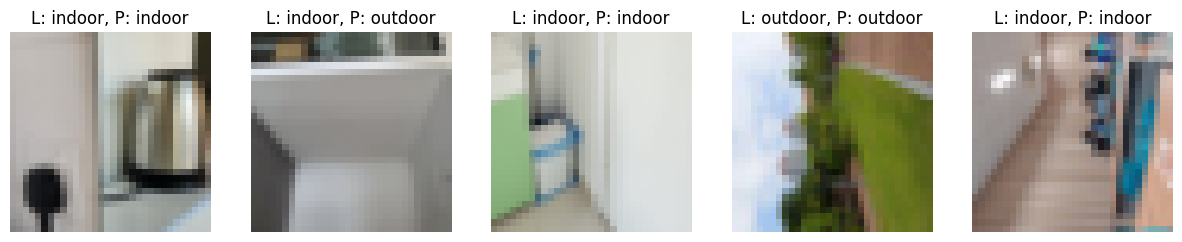

Epoch [60/120], Loss: 0.20050829249407798, Accuracy: 0.9248434237995825


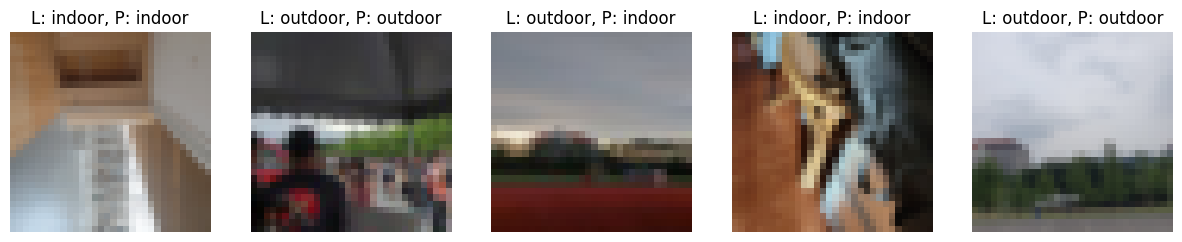

Epoch [90/120], Loss: 0.0708504233888713, Accuracy: 0.9707724425887265


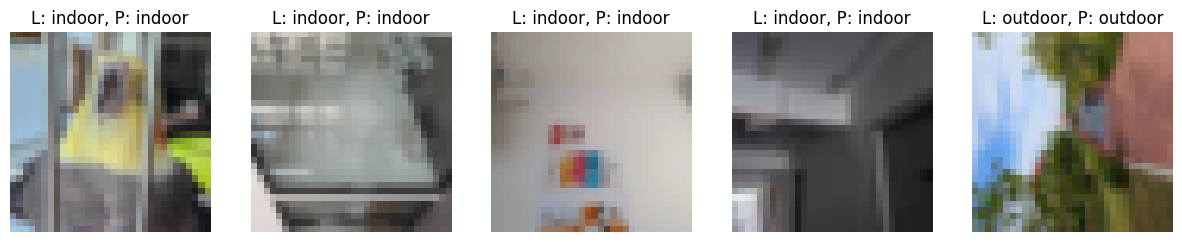

Epoch [120/120], Loss: 0.0013259367792839427, Accuracy: 1.0


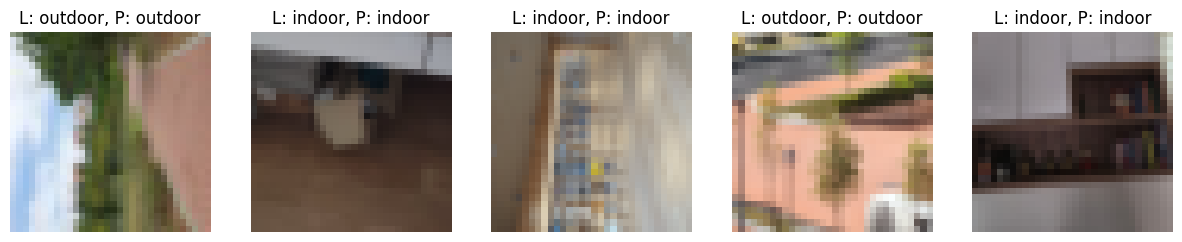

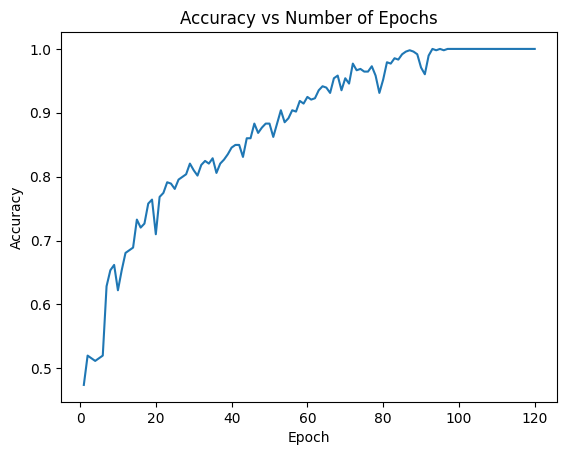

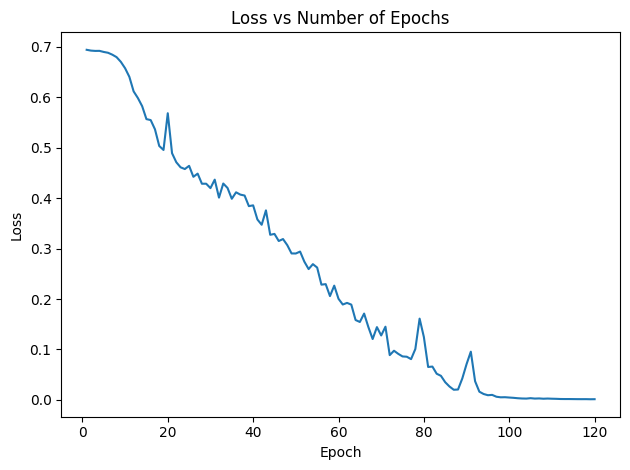

In [22]:
import matplotlib.pyplot as plt

# Array storing the labels
true_labels = []
predicted_labels = []
labels = ["indoor", "outdoor"]  # For class_weights

# Probability distribution
class_weights = torch.tensor([1.0 / labels.count(label) for label in set(labels)])
class_weights = class_weights.to(device)
# Define the criterion
criterion = nn.CrossEntropyLoss(weight = class_weights)

# (w/ unnormalization)
# Training loop (Training datasets)
num_epochs = 120
loss_list = []
accuracy_list = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        # Compute loss
        loss = criterion(outputs, labels)
        # Perform backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Store true labels and predicted labels
        true_labels.extend(labels.tolist())
        predicted_labels.extend(torch.argmax(outputs, dim=1).tolist())

        # Count correct predictions
        correct_predictions += torch.sum(torch.argmax(outputs, dim=1) == labels).item()
        total_predictions += labels.size(0)

    # Calculate accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_predictions
    loss_list.append(epoch_loss)
    accuracy_list.append(epoch_accuracy)

    if (epoch + 1) % 30 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}, Accuracy: {epoch_accuracy}")

        # Display a sample image with labels
        sample_images, sample_labels = next(iter(train_loader))
        sample_images = sample_images.to(device)
        sample_labels = sample_labels.to(device)
        sample_outputs = model(sample_images)
        _, sample_predicted = torch.max(sample_outputs.data, 1)

        # Create a single figure with subplots
        fig, axes = plt.subplots(1, len(sample_images), figsize=(len(sample_images) * 3, 3))

        # Iterate over the images and display them in subplots
        for i, (image, label, predicted) in enumerate(zip(sample_images, sample_labels, sample_predicted)):
            image_np, label, predicted = display_image(image, label, predicted)
            axes[i].imshow(image_np)
            axes[i].axis('off')
            axes[i].set_title(f"L: {label}, P: {predicted}")

        plt.show()

# Plotting the accuracy vs number of epochs
plt.plot(range(1, num_epochs + 1), accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Epochs')
plt.show()

plt.plot(range(1, num_epochs + 1), loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Number of Epochs')
plt.tight_layout()
plt.show()

In [23]:
# Perfomance metrics
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Precision: 0.88
Recall: 0.88
F1 Score: 0.88


In [24]:
# Evaluation on test/validation data
model.eval()
total_correct = 0
total_samples = 0

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

        # Store true labels and predicted labels
        true_labels.extend(labels.tolist())
        predicted_labels.extend(predicted.tolist())

print(f"{total_correct} correct labels over {total_samples} samples")

accuracy = (total_correct / total_samples) * 100
print(f"Network Accuracy: {accuracy}%")

# Calculate precision, recall, F1 score
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

42 correct labels over 59 samples
Network Accuracy: 71.1864406779661%
Precision: 0.88
Recall: 0.88
F1 Score: 0.88


In [25]:
# Accuracy for each class
# Evaluation on test/validation data (Each class)
model.eval()
class_correct = [0, 0]  # Initialize counters for correct predictions per class
class_total = [0, 0]  # Initialize counters for total samples per class

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        batch_size = labels.size(0)

        # Update counters for each class
        for i in range(batch_size):
            label = labels[i]
            prediction = predicted[i]
            if label == prediction:
                class_correct[label] += 1
            class_total[label] += 1

# Calculate accuracy for each class
class_accuracy = [class_correct[i] / class_total[i] * 100 for i in range(len(class_correct))]

# Display accuracy for each class
classes = ['indoor', 'outdoor']
for i in range(len(classes)):
    print(f"For class {classes[i]}: {class_correct[i]} correct labels over {class_total[i]} samples")
    print(f"Accuracy for class {classes[i]}: {class_accuracy[i]:.2f}%\n")


For class indoor: 21 correct labels over 30 samples
Accuracy for class indoor: 70.00%

For class outdoor: 22 correct labels over 29 samples
Accuracy for class outdoor: 75.86%

